## 4.2C Unsupervised learning task outline

**Background**
Build development activity monitor is important for city constructoin and planning, in this task a real world data set from City of Melbourne is provided, it monitors major new commercial and residential property development in the City of Melbourne municipality. Analysis of the data can inform short to medium-term supply forecasts in the commercial and residential markets. This data provides our current understanding of major development sites that are recently completed, under construction, planned or mooted in all of 13 small areas of the city.

**Dataset description**
Dataset contains different features along with the development activity. It contains total 42 features. It contains different types of data including int, float and string. Feature names, data type and values are described in the following link. Each observation is a datapoint along the row of the dataset. The dataset can be found in: https://data.melbourne.vic.gov.au/explore/dataset/development-activitymonitor/information/
    

In [82]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [83]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics, manifold
from sklearn.metrics import silhouette_score, classification_report, homogeneity_score, adjusted_rand_score, rand_score, mutual_info_score,completeness_score, v_measure_score, adjusted_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from collections import Counter
import scipy.cluster.hierarchy as shc
from umap import UMAP
from matplotlib.ticker import NullFormatter



In [84]:
# Read in dataset
df = pd.read_csv("../data/development-activity-monitor.csv")

df.shape
# Output: (1406, 42)

# Show features
# print(df.columns)
# Output: Index(['data_format', 'development_key', 'status', 'year_completed',
#       'clue_small_area', 'clue_block', 'street_address', 'property_id',
#       'property_id_2', 'property_id_3', 'property_id_4', 'property_id_5',
#       'floors_above', 'resi_dwellings', 'studio_dwe', 'one_bdrm_dwe',
#       'two_bdrm_dwe', 'three_bdrm_dwe', 'student_apartments', 'student_beds',
#       'student_accommodation_units', 'institutional_accom_beds',
#       'hotel_rooms', 'serviced_apartments', 'hotels_serviced_apartments',
#       'hostel_beds', 'childcare_places', 'office_flr', 'retail_flr',
#       'industrial_flr', 'storage_flr', 'education_flr', 'hospital_flr',
#       'recreation_flr', 'publicdispaly_flr', 'community_flr', 'car_spaces',
#       'bike_spaces', 'town_planning_application', 'longitude', 'latitude',
#       'geopoint'],
#      dtype='object')

# Drop some columns - mostly identifying variables, and geopoint (repeats latitude/longitutde)
df.drop(columns=['data_format', 'development_key', 'street_address', 'property_id', 'property_id_2', 'property_id_3', 'property_id_4', 'property_id_5', 'town_planning_application', 'year_completed', 'geopoint'], inplace=True)

#Check missing value counts and remove features with a lot of missing values
print(df.isnull().sum())
df = df.dropna()

# Check unique values for potential columns of interest

df['clue_small_area'].unique()
# Output: 
# array(['Carlton', 'Kensington', 'Docklands', 'Melbourne (CBD)',
#       'Parkville', 'North Melbourne', 'Port Melbourne', 'East Melbourne',
#       'West Melbourne (Residential)', 'Southbank',
#       'Melbourne (Remainder)', 'South Yarra',
#       'West Melbourne (Industrial)'], dtype=object)

df['status'].unique()
# Output: 
# array(['COMPLETED', 'APPROVED', 'APPLIED', 'UNDER CONSTRUCTION'],
#       dtype=object)

# Store clue_small_area and status values before mapping
clue_small_area_values = df['clue_small_area'].unique()
status_values = df['status'].unique()

# Map clue_small_area and status to numeric values
df['clue_small_area'] = df['clue_small_area'].map({'Carlton': 1, 'Kensington': 2, 'Docklands': 3, 'Melbourne (CBD)': 4, 'Parkville': 5, 'North Melbourne': 6, 'Port Melbourne': 7, 'East Melbourne': 8, 'West Melbourne (Residential)': 9, 'Southbank': 10, 'Melbourne (Remainder)': 11, 'South Yarra': 12, 'West Melbourne (Industrial)': 13})
df['status'] = df['status'].map({'COMPLETED': 1, 'APPROVED': 2, 'APPLIED': 3, 'UNDER CONSTRUCTION': 4})

# Print the first 5 rows of the dataframe
df.head()

status                         0
clue_small_area                0
clue_block                     0
floors_above                   0
resi_dwellings                 0
studio_dwe                     0
one_bdrm_dwe                   0
two_bdrm_dwe                   0
three_bdrm_dwe                 0
student_apartments             0
student_beds                   0
student_accommodation_units    0
institutional_accom_beds       0
hotel_rooms                    0
serviced_apartments            0
hotels_serviced_apartments     0
hostel_beds                    0
childcare_places               0
office_flr                     0
retail_flr                     0
industrial_flr                 0
storage_flr                    0
education_flr                  0
hospital_flr                   0
recreation_flr                 0
publicdispaly_flr              0
community_flr                  0
car_spaces                     0
bike_spaces                    0
longitude                      0
latitude  

,status,clue_small_area,clue_block,floors_above,resi_dwellings,studio_dwe,one_bdrm_dwe,two_bdrm_dwe,three_bdrm_dwe,student_apartments,...,storage_flr,education_flr,hospital_flr,recreation_flr,publicdispaly_flr,community_flr,car_spaces,bike_spaces,longitude,latitude
0,1,1,255,10,0,0,0,0,0,201,...,0,0,0,0,0,0,0,0,144.963640,-37.804307
1,1,2,520,4,86,0,0,0,0,0,...,0,0,0,0,0,0,0,0,144.925669,-37.796628
2,1,3,1107,3,0,0,0,0,0,0,...,0,5616,0,0,0,0,0,0,144.948611,-37.822022
3,1,3,1107,4,0,0,0,0,0,0,...,0,18000,0,0,0,0,0,0,144.948611,-37.822022
4,1,4,21,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,144.954690,-37.819293


In [85]:
print(df.columns)


Index(['status', 'clue_small_area', 'clue_block', 'floors_above',
       'resi_dwellings', 'studio_dwe', 'one_bdrm_dwe', 'two_bdrm_dwe',
       'three_bdrm_dwe', 'student_apartments', 'student_beds',
       'student_accommodation_units', 'institutional_accom_beds',
       'hotel_rooms', 'serviced_apartments', 'hotels_serviced_apartments',
       'hostel_beds', 'childcare_places', 'office_flr', 'retail_flr',
       'industrial_flr', 'storage_flr', 'education_flr', 'hospital_flr',
       'recreation_flr', 'publicdispaly_flr', 'community_flr', 'car_spaces',
       'bike_spaces', 'longitude', 'latitude'],
      dtype='object')


In [158]:
# Create new df with only lat and long
lat_long = df[['latitude', 'longitude']]           

# Create two separate series for lat and long
lat, long = df.latitude, df.longitude

# Create scatterplot of lat and long
fig = px.scatter(x=long, y=lat, color='clue_small_area', data_frame=df, width=700)
fig.show()

## This plot shows the latitude/longitude locations of the data, colour coded by suburb area (small_clue_area)

_**Question 1**_

1. We are interested in finding optimal number of groups for this dataset, where the ground truth grouping information is represented by `clue_small_area’ feature.

    a. What method shall we use for solving this problem and why?

    b. Does this data suffer from curse of dimensionality? Explain.

    c. Find out optimal number of groups, report the outcome and justify your findings. 

My answers for parts A and B of this question of this question are in the report. Thank you.

In [88]:
# Extract subsets from dataframe
X = df.drop(columns=['status'], axis=1)
y = df['status']

# Standardise data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [89]:
df.shape

(1406, 31)

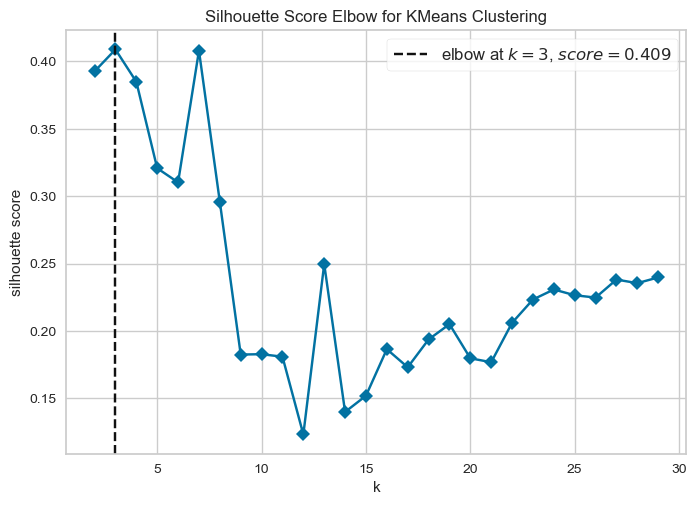

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
#Instantiate the clustering model and visualiser
km = KMeans()
visualizer = KElbowVisualizer(
    km, k=(2,30), metric='silhouette', timings=False
)

visualizer.fit(X)
visualizer.show()

## Silhouette score plot indicates that 3 clusters would be optimum
## If looking to cluster by status, 4 clusters would make more sense since there are four unique status values - COMPLETED, APPROVED, APPLIED, UNDER CONSTRUCTION

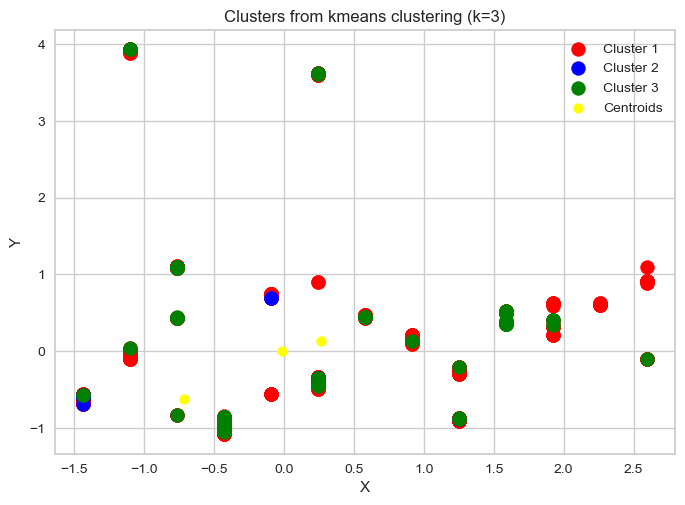

In [150]:
# Instantiate clustering model and fit dataset with 3 clusters
km_model = KMeans(n_clusters=3)
km_model.fit(X)
y_pred = km_model.fit_predict(X)

# Convert X to numpy array
X1 = X.to_numpy()

# Plot the clusters
plt.scatter(X1[y_pred == 0, 0], X1[y_pred == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X1[y_pred == 1, 0], X1[y_pred == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X1[y_pred == 2, 0], X1[y_pred == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(km_model.cluster_centers_[:, 0], km_model.cluster_centers_[:, 1], s = 50, c = 'yellow', label = 'Centroids')
plt.title('Clusters from kmeans clustering (k=3)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## This plot shows that the model is bad at making predictions when k=3, there is a lot of mixing/overlap between clusters and no definition between them

In [149]:
# Instantiate clustering model and fit dataset using 4 clusters (number of unique values in status column)
km_model2 = KMeans(n_clusters=4)
km_model2.fit(X)
y_pred = km_model.fit_predict(X)

# Convert X to numpy array
X1 = X.to_numpy()

# Create a scatter plot of the clusters using Plotly
fig = px.scatter(x=X1[:, 0], y=X1[:, 1], color=df['status'], labels={'color': 'Status'}, width=700)
fig.update_traces(marker=dict(size=10))
fig.update_layout(title='Clusters from kmeans clustering (k=4)', xaxis_title='X', yaxis_title='Y')
fig.show()

## Status key - 1:'COMPLETED', 2:'APPROVED', 3:'APPLIED', 4:'UNDER CONSTRUCTION'
## This plot also shows that my model is bad at predicting status (k=4), there is a lot of mixing/overlap between clusters and no definition between them

In [93]:
#Function to calculate purity score (from section 3.11 in the learning materials)
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [133]:
# Calculate performance metrics

print('Silhouette Score: %.3f' % silhouette_score(X, y_pred))
#print('Silhouette Score: %.3f' % silhouette_score(X, km_model.labels_)) # This also works
print('Sum of Squared Errors (SSE): %.3f' % km_model.inertia_)
print("Purity score: ", format(purity_score(y, y_pred), ".0%"))
print('Rand Index: %.3f' % metrics.rand_score(y, y_pred))
print('Adjusted Rand Index: %.3f' % adjusted_rand_score(y, y_pred))
print('Mutual Information Score: %.3f' % mutual_info_score(y, y_pred))
print('Classification Report: \n', classification_report(y, y_pred))

## Overall the model has not performed well, as the plots above indicate
## A silhouette score of 0.363 indicates that the clusters are not well separated
## A SSE score of 35748.367 indicates that the data points are not close to their respective centroids
## A purity score of 73% indicates that the clusters are reasonably homogenous
## A rand index of 0.568 indicates a moderate match between the predicted and ground truth labels
## An adjusted rand index of 0.083 indicates a poor match between the predicted and ground truth labels, adjusted for chance
## A mutual information score of 0.010 indicates a poor match between the predicted and ground truth labels


Silhouette Score: 0.363
Sum of Squared Errors (SSE): 35748.367
Purity score:  73%
Rand Index: 0.568
Adjusted Rand Index: 0.083
Mutual Information Score: 0.010
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.75      0.88      0.81      1023
           2       0.25      0.15      0.19       229
           3       0.00      0.00      0.00        76
           4       0.00      0.00      0.00        78

    accuracy                           0.66      1406
   macro avg       0.20      0.21      0.20      1406
weighted avg       0.59      0.66      0.62      1406



In [95]:
#Add another column to store the cluster labels
df['cluster'] = km_model.labels_

#See the cluster column appended to the end of the data
df.head()

,status,clue_small_area,clue_block,floors_above,resi_dwellings,studio_dwe,one_bdrm_dwe,two_bdrm_dwe,three_bdrm_dwe,student_apartments,...,education_flr,hospital_flr,recreation_flr,publicdispaly_flr,community_flr,car_spaces,bike_spaces,longitude,latitude,cluster
0,1,1,255,10,0,0,0,0,0,201,...,0,0,0,0,0,0,0,144.963640,-37.804307,1
1,1,2,520,4,86,0,0,0,0,0,...,0,0,0,0,0,0,0,144.925669,-37.796628,1
2,1,3,1107,3,0,0,0,0,0,0,...,5616,0,0,0,0,0,0,144.948611,-37.822022,1
3,1,3,1107,4,0,0,0,0,0,0,...,18000,0,0,0,0,0,0,144.948611,-37.822022,1
4,1,4,21,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,144.954690,-37.819293,0


_**Question 2. Implement two alternative solutions of Q1 (c), except Kmeans/Kmeans++ and Shape-based clustering. Compare and report the findings**_

### Alternative solution 1: DBSCAN

Find the optimum epsilon value

In [98]:
# NearestNeighbors finds the distance between each point and it's nearest neighbour
nn = NearestNeighbors(n_neighbors=2)
X = pd.DataFrame(X)
X = pd.DataFrame(X, columns=X.columns)
neighbours = nn.fit(X)
distances, indices = neighbours.kneighbors(X)

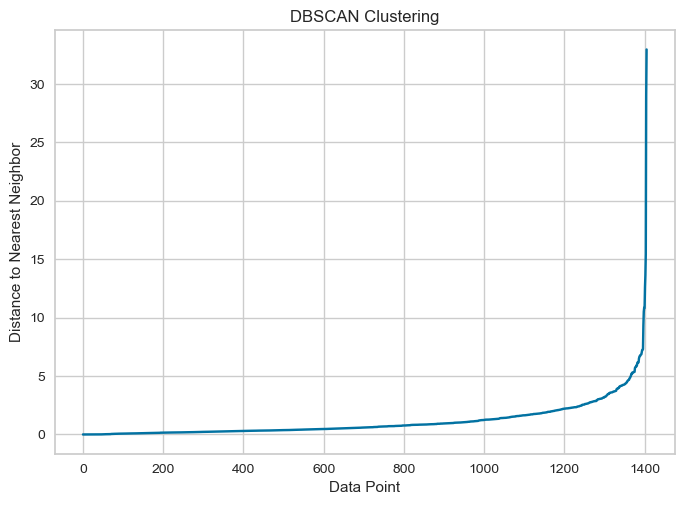

In [99]:
# Fit DBSCAN clustering model to the data
dbscan_model = DBSCAN()
dbscan_model.fit(X)

# Calculate distances to nearest neighbors
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)

# Sort the distances
distances = np.sort(distances[:,1], axis=0)

# Create plot - optimum epsilon is the turning point in the curve
plt.plot(distances)
plt.xlabel('Data Point')
plt.ylabel('Distance to Nearest Neighbor')
plt.title('DBSCAN Clustering')
plt.show()

## Plot shows that the turning point is at approximately (1350, 5), indicating that the optimum epsilon is approximately 5

Find the optimum minimum samples value

In [101]:
## The above plot shows that epsilon is approximately 5, so here I will test values between 3 and 6

min_samples = range(5,12)               #Minimum number of data points in a cluster
eps = np.arange(3, 6, 0.1)              #Start at 3, stop at 6, increment by 0.1

#Empty list to store eps and min_samples
output = [] 

#Iterate to find optimum values - store as eps and min_samples in output list
for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(X).labels_
        output.append((ms, ep))

In [102]:
# Extract the highest values for min_samples and eps from the output list
min_samples, eps = sorted(output, key=lambda x:x[-1])[-1]

#Print optimum values
print(f"Optimum min_samples: {min_samples}")
print(f"Optimum epsilon: {np.round(eps, decimals=3)}")

Optimum min_samples: 11
Optimum epsilon: 5.9


In [104]:
#Counter for counting the number of data points in each clusters
labels = DBSCAN(min_samples=min_samples, eps=eps).fit(X).labels_
clusters = len(Counter(labels))

#Run DBSCAN
db_model = DBSCAN(eps=eps, min_samples=min_samples)
db_pred = db_model.fit_predict(X)
db_purity_score = purity_score(y, db_pred)

#Print counts, silhouette and purity score
print(f"Number of clusters: {clusters}")
print(f"Number of outliers: {Counter(labels)[-1]}")



Number of clusters: 2
Number of outliers: 49


In [105]:
# Performance metrics
print(f"Silhouette score: {np.round(silhouette_score(X, labels), decimals=3)}")
print(f"Homogeneity score: {np.round(homogeneity_score(y, labels), decimals=3)}")
print("Purity score: ", format(db_purity_score, ".0%"))
print(f"V-measure score: {np.round(metrics.v_measure_score(y, labels), decimals=3)}")
print(f"Adjusted Rand Index: {np.round(adjusted_rand_score(y, labels), decimals=3)}")
print(f"Mutual Information Score: {np.round(mutual_info_score(y, labels), decimals=3)}\n")

## A silhouette score of 0.675 indicates that the clusters are well separated and distinct from each other
## A purity score of 73% indicates that only 73% of data points belong to the same class, this makes sense considering the homogeneity score is only 0.002 which indicates that that clusters are not very homogenous and there is a lot of mixing occuring.
## The adjusted rand index and mutual information score are both very low which indicates that the model is bad at making accurate predictions

Silhouette score: 0.675
Homogeneity score: 0.002
Purity score:  73%
V-measure score: 0.003
Adjusted Rand Index: 0.001
Mutual Information Score: 0.002



### Alternative solution 2: Agglomerative hierarchical clustering 

In [ ]:
## Run PCA on the data using 2 components

n_components = 2

#Instantiate PCA model
pca = PCA(n_components=n_components)

#Fit the PCA model to the data, transform the data using the fitted PCA model 
components = pca.fit_transform(X)
components = pd.DataFrame(components)
components.columns = ['PC1', 'PC2']

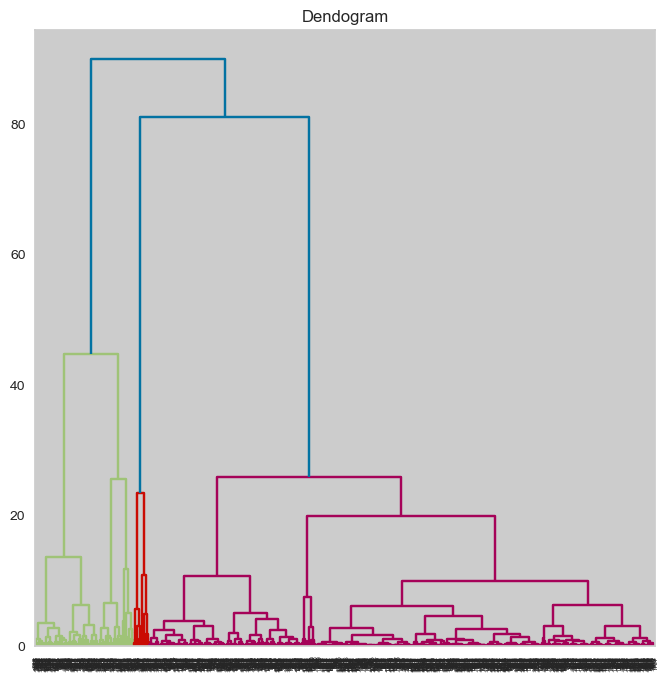

In [ ]:
# Plot the dendrogram
plt.figure(figsize =(8, 8))
plt.title('Dendogram')
Dendrogram = shc.dendrogram((shc.linkage(components, method ='ward')))

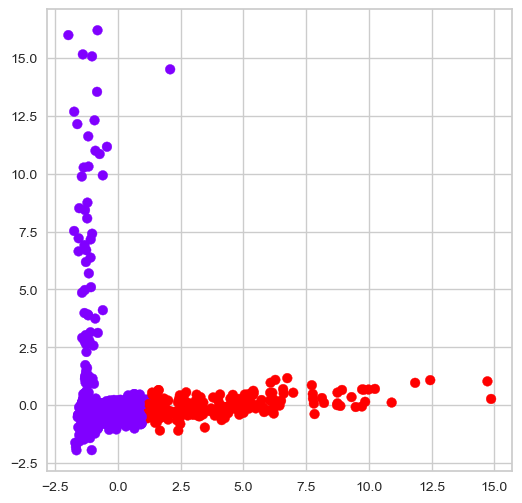

In [ ]:
# Clustering with k=2 clusters

ac2 = AgglomerativeClustering(n_clusters=2)
labels = ac2.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = ac2.fit_predict(components), cmap='rainbow')
plt.show()

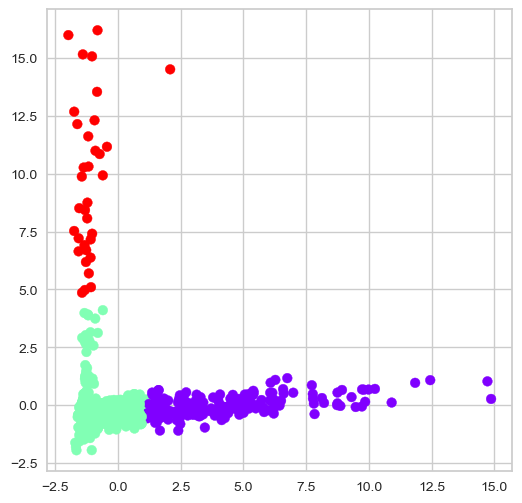

In [ ]:
# Clustering with k=3 clusters

ac3 = AgglomerativeClustering(n_clusters=3)
labels = ac3.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = ac3.fit_predict(components), cmap='rainbow')
plt.show()

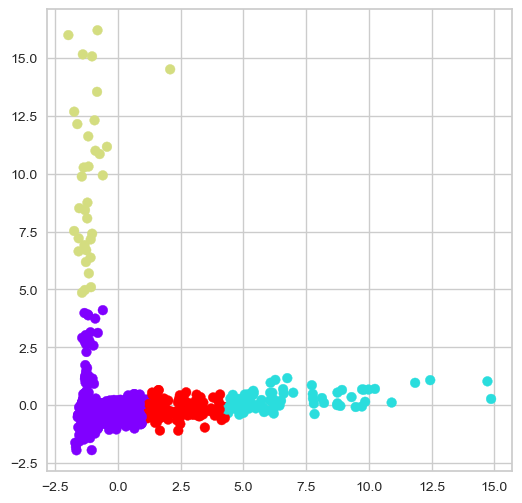

In [ ]:
# Clustering with k=4 clusters

ac4 = AgglomerativeClustering(n_clusters=4)
labels = ac4.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = ac4.fit_predict(components), cmap='rainbow')
plt.show()

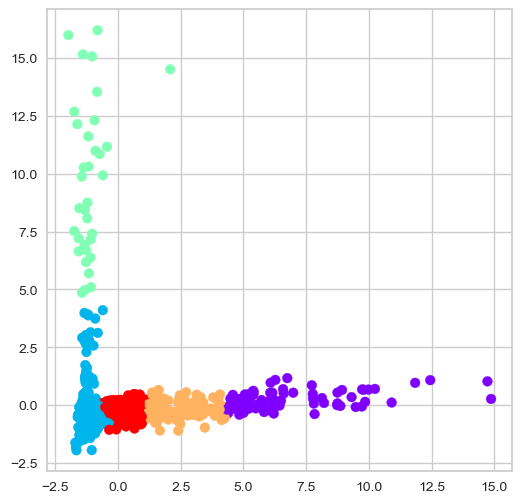

In [ ]:
# Clustering with k=5 clusters

ac5 = AgglomerativeClustering(n_clusters=5)
labels = ac5.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = ac5.fit_predict(components), cmap='rainbow')
plt.show()

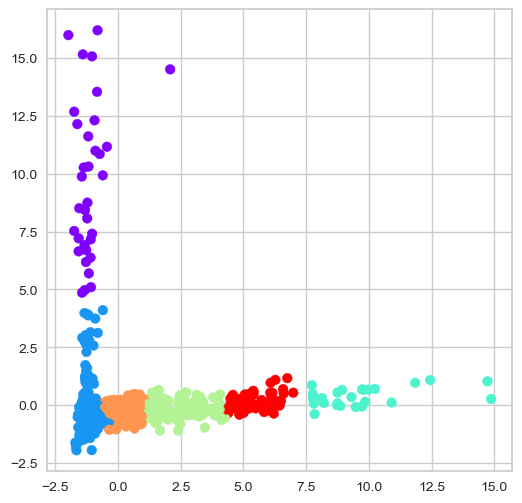

In [ ]:
# Clustering with k=6 clusters

ac6 = AgglomerativeClustering(n_clusters=6)
labels = ac6.fit_predict(X)

# Plot the clusters
plt.figure(figsize=(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = ac6.fit_predict(components), cmap='rainbow')
plt.show()

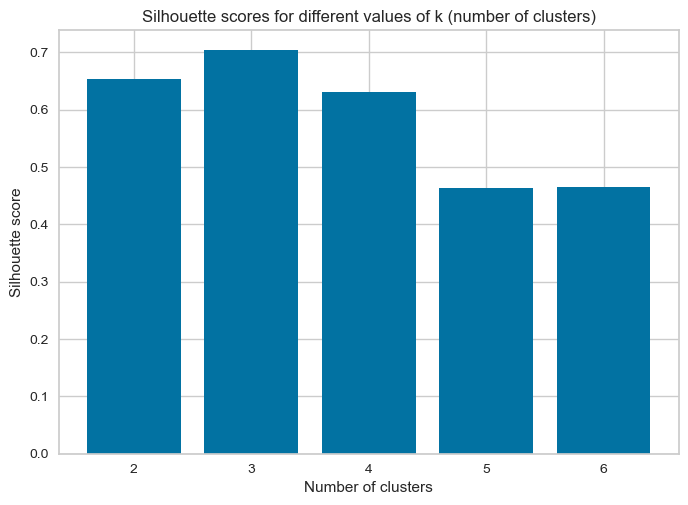

In [ ]:
# Find the optimum k value using the silhouette score

k = [2, 3, 4, 5, 6]
 
# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(components, ac2.fit_predict(components)))
silhouette_scores.append(
        silhouette_score(components, ac3.fit_predict(components)))
silhouette_scores.append(
        silhouette_score(components, ac4.fit_predict(components)))
silhouette_scores.append(
        silhouette_score(components, ac5.fit_predict(components)))
silhouette_scores.append(
        silhouette_score(components, ac6.fit_predict(components)))
 
# Plotting a bar graph to compare the results
plt.title('Silhouette scores for different values of k (number of clusters)')
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

## The plot shows that the optimum number of clusters is 3 (k=3)

In [ ]:
# Performance metrics - choose from silhouette score, homogeneity score, completeness, v-measure, adjusted rand index, adjusted mutual info score

print(f"Silhouette score: {np.round(silhouette_score(X, labels), decimals=3)}")
print(f"Homogeneity score: {np.round(homogeneity_score(y2b, labels), decimals=3)}")
print(f"Completeness score: {np.round(completeness_score(y2b, labels), decimals=3)}")
print(f"V-measure score: {np.round(v_measure_score(y2b, labels), decimals=3)}")
print(f"Adjusted Rand Index: {np.round(adjusted_rand_score(y2b, labels), decimals=3)}")
print(f"Adjusted Mutual Information Score: {np.round(adjusted_mutual_info_score(y2b, labels), decimals=3)}\n")

## A silhouette score of 0.358 indicates that the clusters are somewhat well separated but that there is still some overlap
## Homogeneity and completeness are both low, indicating that the clusters are not very homogenous or complete and that there is mixing between clusters
## V-measure, ARI and AMI scores are low, indication that the model is not very good at making predictions


Silhouette score: 0.358
Homogeneity score: 0.017
Completeness score: 0.024
V-measure score: 0.02
Adjusted Rand Index: 0.093
Adjusted Mutual Information Score: 0.013



_**Question 3. Implement two alternative solutions of Q1 (c) using Shape-based clustering**_

I attempted to run VAT and iVAT for this question but both require the package pyclustertend which I sadly could not get to work (even when reverting to an older version of Python).


### Alternative solution: Spectral clustering

In [ ]:
## Run PCA on the data using 2 components

n_components = 2

#Instantiate PCA model
pca = PCA(n_components=n_components)

#Fit the PCA model to the data, transform the data using the fitted PCA model 
components = pca.fit_transform(X)
components = pd.DataFrame(components)
components.columns = ['PC1', 'PC2']


In [ ]:
# Spectral clustering using rbf
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity ='rbf')
labels_rbf = spectral_model_rbf.fit_predict(components)

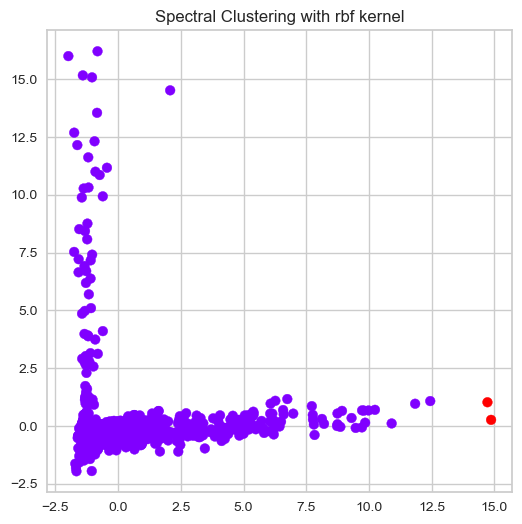

In [ ]:
# Create plot for spectral clustering model
plt.figure(figsize =(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = labels_rbf, cmap='rainbow')
plt.title('Spectral Clustering with rbf kernel')
plt.show()


In [ ]:
## Performance metrics - choose from silhouette score, connectivity, clustering validity indices, eigengap heuristic, excess risk bounds

print(f"Silhouette score (rbf): {np.round(silhouette_score(X, labels_rbf), decimals=3)}")
print(f"Adjusted Rand Index (rbf): {np.round(adjusted_rand_score(y3, labels_rbf), decimals=3)}")

## The silhouette score for rbf indicates that the clusters are reasonably well separated
## It suggests that there is little to no overlap occuring and the individual data points are well matched to their own clusters
## The adjusted rand index is negative and quite close to zero, indicating that the model performs very slightly worse than random chance when making predictions

Silhouette score (rbf): 0.65
Adjusted Rand Index (rbf): -0.002


In [153]:
# Spectral clustering using nearest neighbours
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity ='nearest_neighbors')
labels_nn = spectral_model_nn.fit_predict(components)

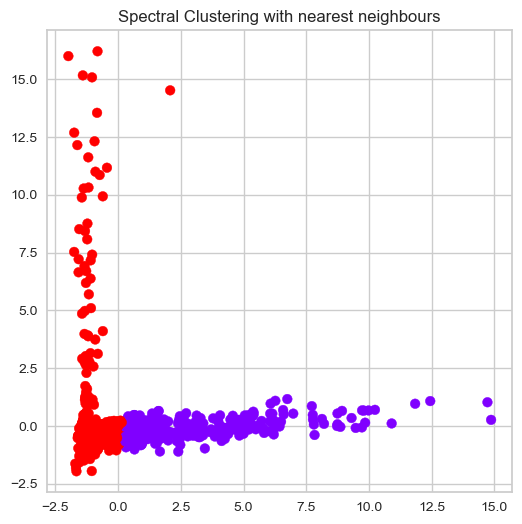

In [154]:
# Create plot for spectral clustering model
plt.figure(figsize =(6, 6))
plt.scatter(components['PC1'], components['PC2'], c = labels_nn, cmap='rainbow')
plt.title('Spectral Clustering with nearest neighbours')
plt.show()

In [155]:
## Performance metrics - choose from silhouette score, connectivity, clustering validity indices, eigengap heuristic, excess risk bounds

print(f"Silhouette score (nearest neighbours): {np.round(silhouette_score(X, labels_nn), decimals=3)}")
print(f"Adjusted Rand Index (nearest neighbours): {np.round(adjusted_rand_score(y3, labels_nn), decimals=3)}")

## The silhouette score for nearest neighbors is 0.245. This score indicates that the clusters are not well separated.
## The adjusted rand index is negative and quite close to zero, indicating that the model performs somewhat better than random chance when making predictions

Silhouette score (nearest neighbours): 0.245
Adjusted Rand Index (nearest neighbours): 0.094


_**Question 4. Evaluate quality of the groupings that you have reported as a solution of Q1 (c), Q2 and Q3. Based on the evaluation outcomes, report the best solution and explain the results**_

**Quality of groupings for question 1**
The quality of groupings for question 1 (kmeans clustering) is poor. A silhouette score of 0.363 indicates that the clusters are not well separated. The scatterplots for k=3 and k=4 also show this, with clusters lacking clear boundaries and showing significant overlap/mixing between the clusters.

**Quality of groupings for question 2**
For question 2, the quality of groupings differs between the two clustering methods.
- DBSCAN had a silhouette score of 0.675, indicating that the clusters are fairly well separated.
- Agglomerative hierarchical clustering had a silhouette score of 0.358 suggesting that the clusters are not well separated and may have some overlap. The scatterplot shows reasonably well defined clusters with some overlap of data points that are further from the cluster centres.

**Quality of groupings for question 3**
For question 3, the quality of groupings differs depending on the affinity value. 
- For spectral clustering with radial basis function (rbf), the silhouette score was 0.65 indicating that the clusters are reasonably well separated and that the individual data points are well matched to their own clusters (rather than to other clusters).
- For spectral clustering with nearest neighbours however, the silhouette score is much lower (0.245). This indicates that the clusters are not well separated. The scatterplot shows that the clusters are reasonably well defined but still with some overlap of data points that are further from the cluster centres.

_**Question 5. Quantify and print the relationship among independent variables of this dataset (development-activity-monitor.csv). Calculate three collective variables, using two different approaches: i) except PCA and ii) using UMAP, that represent the same dataset. Create two three-dimensional plots to display the relationship between these new variables and explain the plot**_

t-SNE

Text(0.5, 1.0, 'Correlation matrix for independent variables (all)')

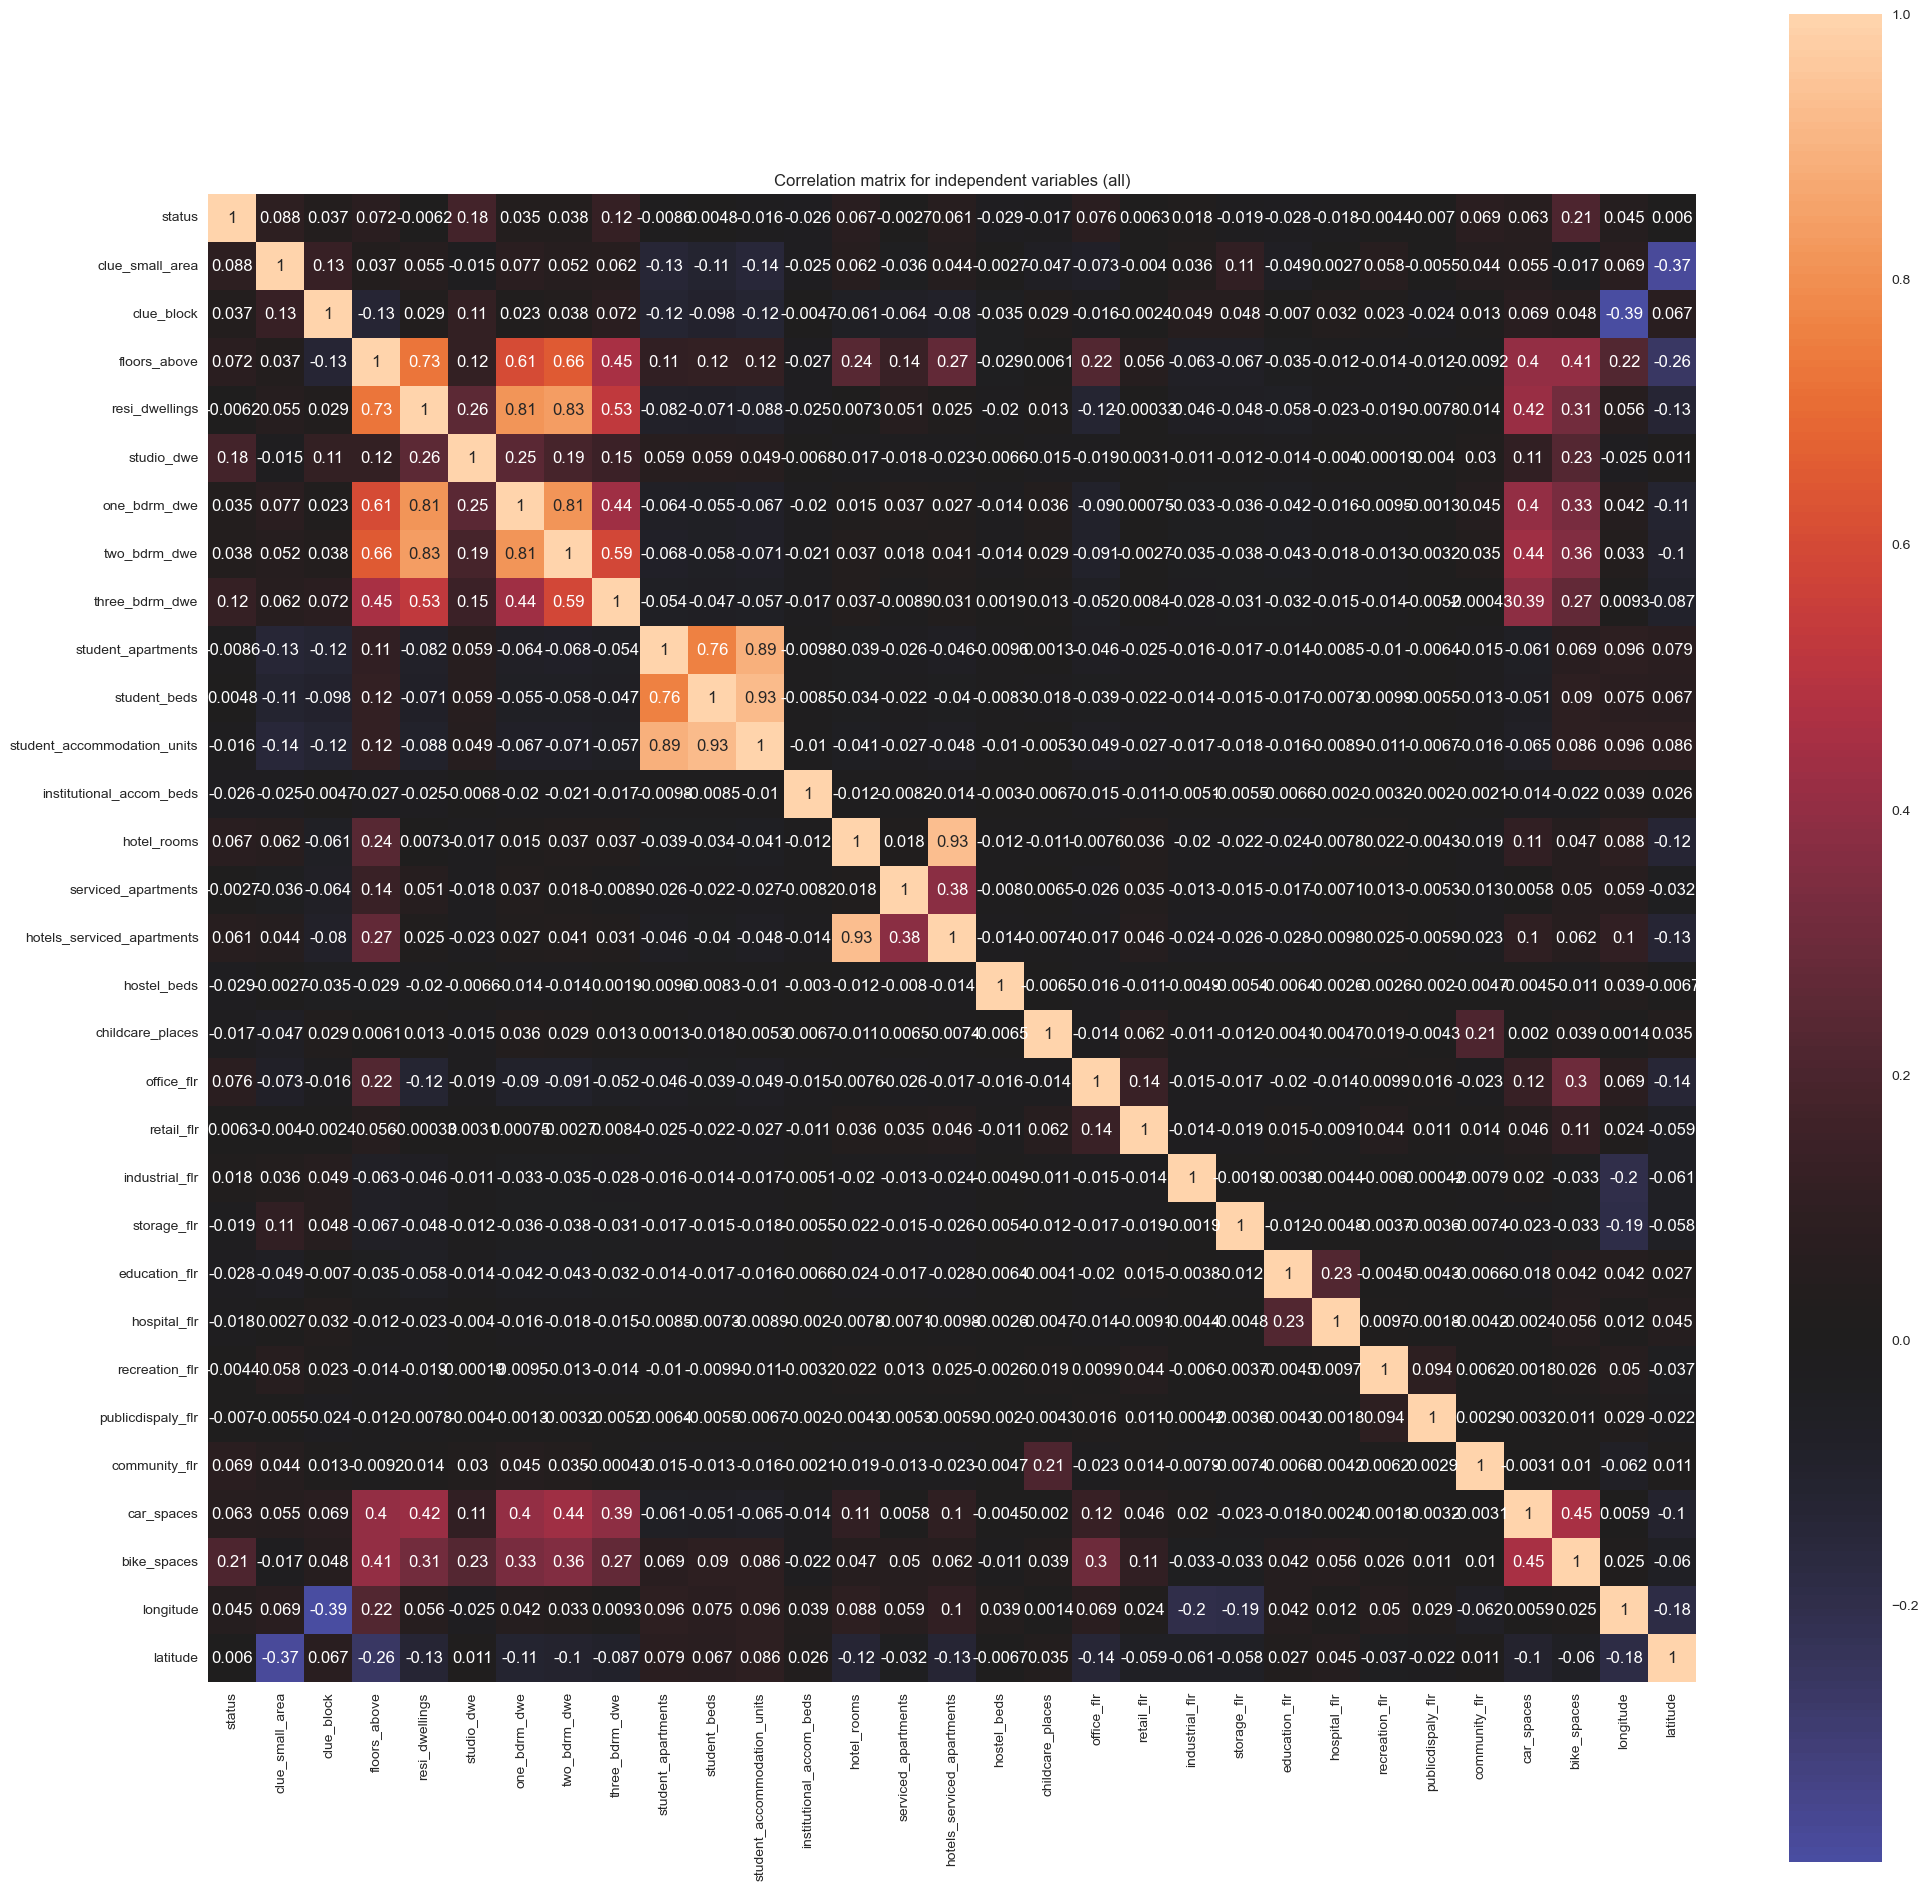

In [ ]:
# Correlation matrix for independent variables
plt.figure(figsize=(24,24))
corr=df.corr()
sns.heatmap(corr,square=True,center=0,annot=True)
plt.title('Correlation matrix for independent variables (all)')

## This correlation matrix is unwieldy and difficult to interpret so I have created a filtered on below

Text(0.5, 1.0, 'Correlation matrix for independent variables (correlation > 0.5)')

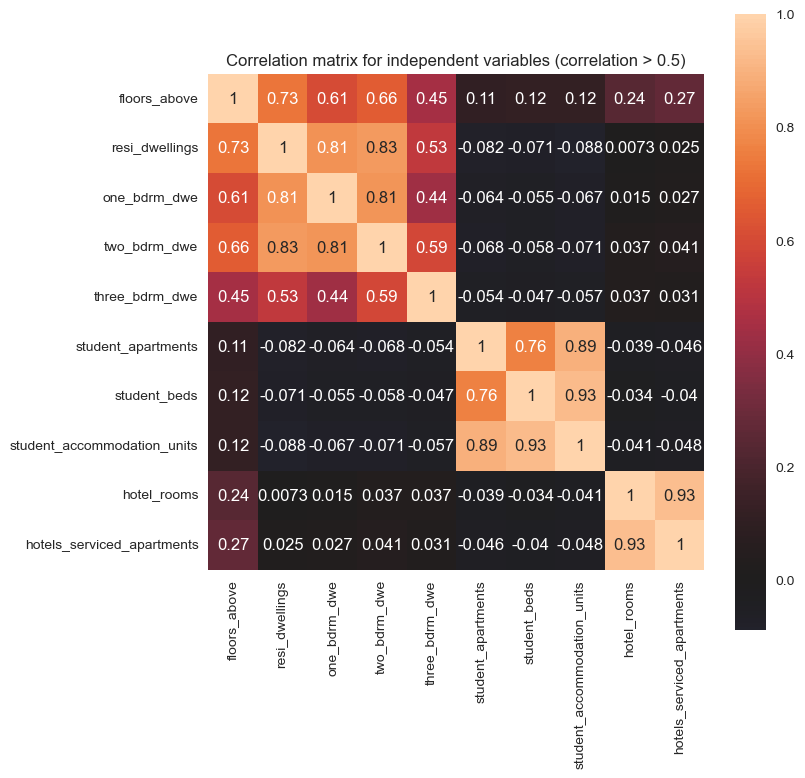

In [ ]:
# Correlation matrix for independent variables - where correlation is greater than 0.5 to filter out variables with low/no correlation
plt.figure(figsize=(8,8))
high_corr_columns=df.columns[list(df.corr().apply( lambda value: value>0.5 ).sum()>1)]
corr=df.corr().loc[high_corr_columns,high_corr_columns]
sns.heatmap(corr,square=True,center=0,annot=True)
plt.title('Correlation matrix for independent variables (correlation > 0.5)')

## The correlation matrix shows strong positive correlations between:
## - resi_dwellings, one_bdrm_dwe, and two_bdrm_dwe
## - student_beds, student_apartments, and student_accommodation_units 
## - hotel_rooms and hotel_serviced_apartments
## The correlation matrix also shows moderate positive correlations between:
## - floors_above, resi_dwellings, one_bdrm_dwe, two_bdrm_dwe
## The dataset could benefit from dimensionality reduction to reduce the number of features and improve the models performance

In [159]:
# Tune perplexity (expected number of neighbours in a cluster)

perplexity = [2, 5, 10, 20, 30, 40, 50, 100]
divergence = [] #Empty list to store the divergence values

for p in perplexity:
    #Apply t-SNE to the first three components
    tsne = TSNE(n_components=3, random_state=42, perplexity=p)
    projections = tsne.fit_transform(X)
    divergence.append(tsne.kl_divergence_)
    #Plot the components - tSNE
    fig = px.scatter_3d(x=projections[:, 0], y=projections[:, 1], z=projections[:, 2])
    fig.update_layout(width=800, height=500)
    fig.update_layout(title='t-SNE (perplexity = ' + str(p) + ')',
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3')
        )
    fig.update_traces(marker=dict(size=5, color=y, colorscale='rainbow', opacity=0.8))
    fig.show()

fig.update_layout(width=1000, height=700)
fig.show()
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(width=1000, height=700)
fig.update_layout(title="Divergence vs Perplexity", xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
#Plot the components - tSNE
fig = px.scatter_3d(x=projections[:, 0], y=projections[:, 1], z=projections[:, 2])
fig.update_layout(title='t-SNE',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3')
    )
fig.update_traces(marker=dict(size=5, color=y, colorscale='rainbow', opacity=0.8))
fig.show()

UMAP (Uniform Manifold Approximation Projection)

In [ ]:
# Run UMAP, fit to data
embedding = UMAP(random_state=42).fit_transform(X) 

embedding.shape

(1406, 2)

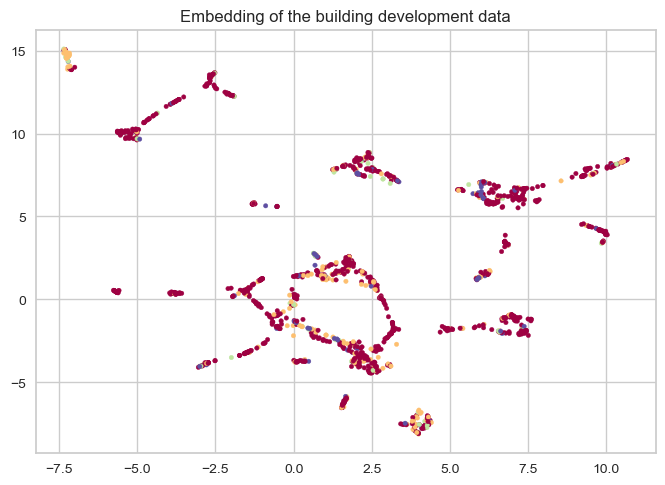

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, c=ya, cmap='Spectral')
plt.title('Embedding of the building development data');

_**Question 6. Is there any loss of information due to the transformation performed in Q5? Explain your answer with evidence**_

The written component of my answer for this question is in the report. Thank you.


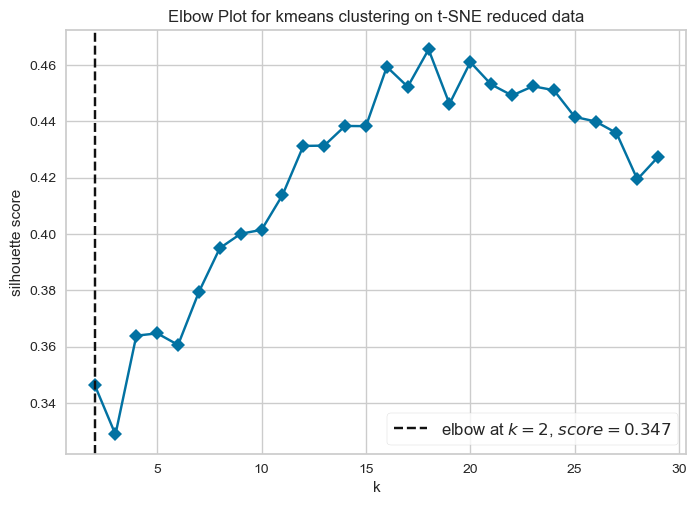

<Axes: title={'center': 'Elbow Plot for kmeans clustering on t-SNE reduced data'}, xlabel='k', ylabel='silhouette score'>

In [135]:
## Run kmeans on t-SNE reduced data

#Create copies of the data
X1 = pd.DataFrame(projections)
Y1 = y

#Instantiate clustering model and visualiser
km1 = KMeans()
km_pred1 = km1.fit_predict(X1)

visualizer1 = KElbowVisualizer(
    km1, k=(2,30), metric='silhouette', timings=False

)
#add title to visualizer
visualizer1.title = 'Elbow Plot for kmeans clustering on t-SNE reduced data'
visualizer1.fit(X1)        #Fit the scaled data to the visualiser
visualizer1.show()

In [131]:
# Performance metrics - t-SNE reduced data
print("Silhouette score: ", np.round(silhouette_score(X1, km1.labels_, metric='euclidean'), decimals=3))
print("Purity score: ", format(purity_score(Y1, km_pred1), ".0%"))
print("Classification report: \n", classification_report(Y1, km_pred1))

Silhouette score:  0.462
Silhouette score:  0.46
Purity score:  73%
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.65      0.08      0.15      1023
           2       0.29      0.14      0.19       229
           3       0.03      0.07      0.04        76
           4       0.09      0.28      0.13        78
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.10      1406
   macro avg       0.13      0.07      0.06      1406
weighted avg       0.53      0.10      0.15      1406



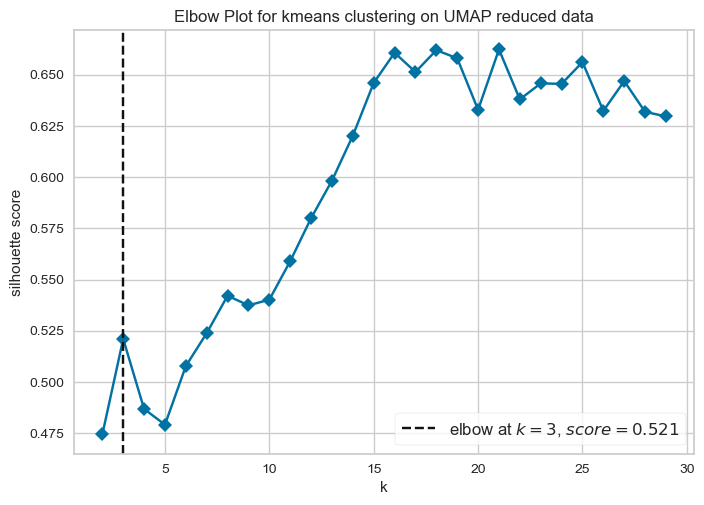

<Axes: title={'center': 'Elbow Plot for kmeans clustering on UMAP reduced data'}, xlabel='k', ylabel='silhouette score'>

In [136]:
## Run kmeans on UMAP reduced data

#Create a copy of the data
X1 = pd.DataFrame(embedding)

#Instantiate clustering model and visualiser
km2 = KMeans()
km_pred2 = km2.fit_predict(X1)

visualizer1 = KElbowVisualizer(
    km2, k=(2,30), metric='silhouette', timings=False
)
visualizer1.title = 'Elbow Plot for kmeans clustering on UMAP reduced data'
visualizer1.fit(X1)        #Fit the scaled data to the visualiser
visualizer1.show()

In [124]:
# Performance metrics - UMAP reduced data
print("Silhouette score: ", np.round(silhouette_score(X1, km1.labels_, metric='euclidean'), decimals=3))
print("Purity score: ", format(purity_score(y, km_pred1), ".0%"))
print("Classification report: \n", classification_report(y, km_pred1))

Silhouette score:  0.462
Purity score:  73%
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.65      0.08      0.15      1023
           2       0.29      0.14      0.19       229
           3       0.03      0.07      0.04        76
           4       0.09      0.28      0.13        78
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.10      1406
   macro avg       0.13      0.07      0.06      1406
weighted avg       0.53      0.10      0.15      1406

